## Analysis of batch 295
* Compare task-modulation / gain in ON vs. OFF BF units.
* 295 data is IC data recorded by Sean Slee. In his 2015 [J. neurosci ms](https://www.jneurosci.org/content/jneuro/35/38/13090.full.pdf), he showed evidence for a mixture of local and global gain supprsession during pure-tone detection behavior.
* Goal here is to see if NEMS stategain models, fit on the same data, reproduce the effects he was seeing

### Procedure
* In scripts saved in `nems_db/nems_lbhb/pupil_behavior_scripts/` I did the following:
    * used Greg's STRF code to cache a BF for each recorded unit in batch 295. I used all the data for this (i.e. I used all the data that went into the NEMS model)
    * performed a db query for each cell to look up the target freq for each recording file. I cached these as well.
    * I ran the following chunk of code in `pupil_behavior_dump_csv.py` to cache NEMS model results
```
# batch 295 behavior only
state_list = ['st.fil','st.fil0']
basemodel2 = "-ref-psthfr.s_stategain.S"
loader = "psth.fs20-ld-"
batches = [295]
for batch in batches:
    d = get_model_results_per_state_model(batch=batch, state_list=state_list,
                                          basemodel=basemodel2, loader=loader)
    d.to_csv('d_'+str(batch)+'_fil_stategain.csv')        
```

* Since all these results are cached in `nems_db`, this notebook should run just fine in any local python environment where you've pulled down the latest `nems_db

### Define path and import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
# define local nems_db path (I'm working on muskrat right now)
db_path = '/auto/users/hellerc/code/nems_db/'

### Define global analysis params

In [3]:
batch = 295
cutoff = 0.5   # octaves from target freq to be considered ON BF

### Load cached results and merge into single df

In [4]:
# load model results data
dMI = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_fil_stategain.csv'.format(batch), index_col=0)
dMI['r'] = [np.float(r.strip('[]')) for r in dMI['r'].values]
dMI['r_se'] = [np.float(r.strip('[]')) for r in dMI['r_se'].values]

# merge shuffled results and non-shuffled results in order to compute unique MI
file_merge = dMI[dMI['state_sig']=='st.fil'][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']].merge(\
                dMI[dMI['state_sig']=='st.fil0'][['cellid', 'state_chan_alt', 'MI', 'g', 'd', 'r', 'r_se']], \
                on=['cellid', 'state_chan_alt'])

file_merge['gain'] = file_merge['g_x']
file_merge['MI'] = file_merge['MI_x'] - file_merge['MI_y']
file_merge['dc'] = file_merge['d_x']

# define list of significant cells (cells where state improved model preds)
sig_cells = file_merge[(file_merge['r_x'] - file_merge['r_y']) > \
                       (2 * file_merge['r_se_x'])].cellid.unique()

# strip extraneous columns from the merge
strip_cols = [c for c in file_merge.columns if ('_x' in c) | ('_y' in c)]
file_merge = file_merge.drop(columns=strip_cols)

# load BF / SNR data
dBF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tuning.csv'.format(batch), index_col=0)
dBF.index.name = 'cellid'

# load tar frequencies
dTF = pd.read_csv(db_path+'nems_lbhb/pupil_behavior_scripts/d_{}_tar_freqs.csv'.format(batch), index_col=0)

# merge results into single df for 307 and for 309
df = file_merge.merge(dTF, on=['cellid', 'state_chan_alt'])
df.index = df.cellid
df = df.drop(columns=['cellid'])

df = df.merge(dBF, left_index=True, right_index=True)

# add column classifying octave sep. from target
df['oct_diff'] = abs(np.log2(df['tar_freq'] / df['BF']))

# add column for significance
df['sig'] = [True if c in sig_cells else False for c in df.index]

# add column for on cells / off cells
df['ON_BF'] = [True if df.iloc[i]['oct_diff']<=cutoff else False for i in range(df.shape[0])]
df['OFF_BF'] = [True if df.iloc[i]['oct_diff']>cutoff else False for i in range(df.shape[0])]

In [5]:
df.head()

,state_chan_alt,gain,MI,dc,tar_freq,BF,SNR,oct_diff,sig,ON_BF,OFF_BF
cellid,,,,,,,,,,,
btn003b-b1,ACTIVE_1,-1.435201,-0.315503,-0.770677,1000.0,555.0,1.298270,0.849440,True,False,True
btn003c-b1,ACTIVE_1,0.191252,0.093433,0.142109,700.0,685.0,0.764438,0.031251,True,True,False
btn003c-b1,ACTIVE_2,0.553658,0.193866,0.354616,4000.0,685.0,0.764438,2.545824,True,False,True
btn006a-b1,ACTIVE_1,-0.934566,-0.446942,-0.359851,10000.0,9801.0,4.075776,0.028999,True,True,False
btn008b-a1,ACTIVE_1,-0.204644,-0.033599,-0.059641,1200.0,397.0,4.660756,1.595823,True,False,True


### Plot histogram of MI / gain / DC for all cells

/auto/users/hellerc/anaconda3/envs/crh_nems/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'on: -0.071, off: -0.155, \non_pval: 0.327, off_pval: 0.253')

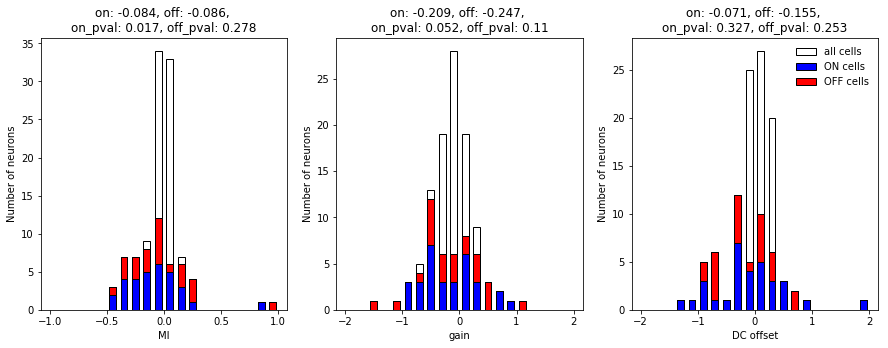

In [6]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

mi_bins = np.arange(-1, 1.1, 0.1)
ax[0].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['MI'], 
           bins=mi_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[0].hist([df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['MI'], 
            df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['MI']],
           color=['blue', 'red'], bins=mi_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[0].set_xlabel('MI', fontsize=10)
ax[0].set_ylabel('Number of neurons', fontsize=10)

gain_bins = np.arange(-2, 2.2, 0.2)
ax[1].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['gain'], 
           bins=gain_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[1].hist([df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['gain'], 
            df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['gain']],
           color=['blue', 'red'], bins=gain_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[1].set_xlabel('gain', fontsize=10)
ax[1].set_ylabel('Number of neurons', fontsize=10)

dc_bins = np.arange(-2, 2.2, 0.2)
ax[2].hist(df.groupby(by=['cellid', 'ON_BF']).mean()['dc'], 
           bins=dc_bins, color='white', edgecolor='k', rwidth=0.6, label='all cells')
ax[2].hist([df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['dc'], 
            df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['dc']],
           color=['blue', 'red'], bins=dc_bins, edgecolor='k', rwidth=0.6, 
           label=['ON cells', 'OFF cells'], histtype='barstacked')
ax[2].set_xlabel('DC offset', fontsize=10)
ax[2].set_ylabel('Number of neurons', fontsize=10)
ax[2].legend(frameon=False, fontsize=10)


# add stats

# MI
on_median = np.round(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['MI'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['MI']).pvalue, 3)
off_median = np.round(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['MI'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['MI']).pvalue, 3)
ax[0].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))
# gain
on_median = np.round(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['gain'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['gain']).pvalue, 3)
off_median = np.round(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['gain'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['gain']).pvalue, 3)
ax[1].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))

# DC
on_median = np.round(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['dc'].median(), 3)
on_pval = np.round(ss.wilcoxon(df[df['sig'] & df['ON_BF']].groupby(by='cellid').mean()['dc']).pvalue, 3)
off_median = np.round(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['dc'].median(), 3)
off_pval = np.round(ss.wilcoxon(df[df['sig'] & df['OFF_BF']].groupby(by='cellid').mean()['dc']).pvalue, 3)
ax[2].set_title('on: {0}, off: {1}, \n'
                'on_pval: {2}, off_pval: {3}'.format(on_median, off_median, on_pval, off_pval))


### Compare ON vs. OFF BF MI / gain / DC for cellids that were recorded in both conditions

In [7]:
on_cells = df[df['ON_BF']].index.unique()
off_cells = df[df['OFF_BF']].index.unique()
matched = np.unique([c for c in df.index.unique() if (c in on_cells.values) & (c in off_cells.values)])
print('{0} cellids found for both condtions'.format(len(matched)))

19 cellids found for both condtions


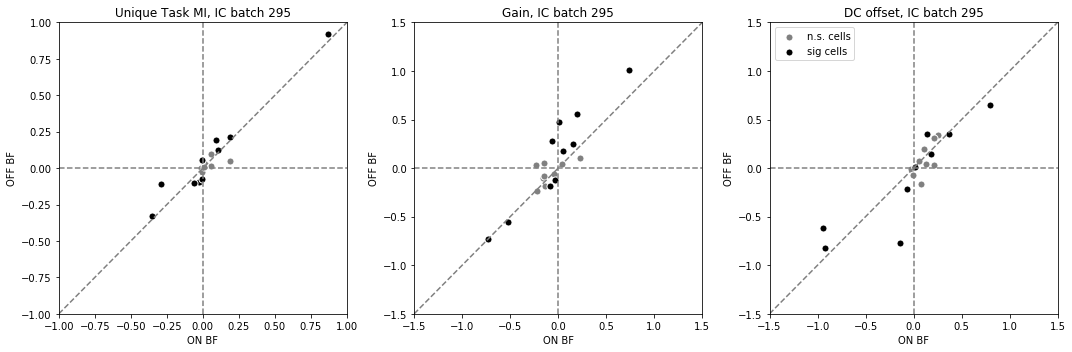

In [8]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

taskON = df[df.index.isin(matched) & (df.oct_diff <= cutoff)].groupby(by='cellid').mean()
taskOFF = df[df.index.isin(matched) & (df.oct_diff > cutoff)].groupby(by='cellid').mean()

ax[0].set_title('Unique Task MI, IC batch 295')
ax[0].scatter(taskON['MI'], taskOFF['MI'], color='grey', edgecolor='white', s=50)
ax[0].scatter(taskON[taskON.sig]['MI'], 
                taskOFF[taskOFF.sig]['MI'], color='k', edgecolor='white', s=50)
ax[0].plot([-1, 1], [-1, 1], 'grey', linestyle='--')
ax[0].axhline(0, linestyle='--', color='grey')
ax[0].axvline(0, linestyle='--', color='grey')
ax[0].set_xlim((-1, 1))
ax[0].set_ylim((-1, 1))
ax[0].set_xlabel('ON BF')
ax[0].set_ylabel('OFF BF')

axlim = 1.5
ax[1].set_title('Gain, IC batch 295')
ax[1].scatter(taskON['gain'], taskOFF['gain'], color='grey', edgecolor='white', s=50)
ax[1].scatter(taskON[taskON.sig]['gain'], 
                taskOFF[taskOFF.sig]['gain'], color='k', edgecolor='white', s=50)
ax[1].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[1].axhline(0, linestyle='--', color='grey')
ax[1].axvline(0, linestyle='--', color='grey')
ax[1].set_xlim((-axlim, axlim))
ax[1].set_ylim((-axlim, axlim))
ax[1].set_xlabel('ON BF')
ax[1].set_ylabel('OFF BF')

ax[2].set_title('DC offset, IC batch 295')
ax[2].scatter(taskON['dc'], taskOFF['dc'], color='grey', edgecolor='white', s=50, label='n.s. cells')
ax[2].scatter(taskON[taskON.sig]['dc'], 
                taskOFF[taskOFF.sig]['dc'], color='k', edgecolor='white', s=50, label='sig cells')
ax[2].plot([-axlim, axlim], [-axlim, axlim], 'grey', linestyle='--')
ax[2].axhline(0, linestyle='--', color='grey')
ax[2].axvline(0, linestyle='--', color='grey')
ax[2].legend()
ax[2].set_xlim((-axlim, axlim))
ax[2].set_ylim((-axlim, axlim))
ax[2].set_xlabel('ON BF')
ax[2].set_ylabel('OFF BF')

f.tight_layout()